In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions
TWO_STAGE = True

In [2]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Session3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

if TWO_STAGE:
    # num_sessions = 40 - cfg.training.num_held_out_sessions
    # MAX_BATCH_SIZE = 15625
    num_sessions = len(held_in_session_ids)
    MAX_BATCH_SIZE = 62500 // 2
    batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions
    
    d, held_out_session_ids = multisession.load_stim_batched(                                                             
        window_size=WINDOW_SIZE,                                                               
        session_subdir="torchraw",                                                     
        data_dir=DATA_DIR,
        unpack_stiminds=True,
        # held_in_session_ids=held_in_session_ids,
        batch_size=batch_size,
        num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
    )
    data_train, data_test = d.train_test_split(5000, test_cut=2500)
    num_sessions = len(held_in_session_ids)
else:
    num_sessions = len(held_in_session_ids)
    MAX_BATCH_SIZE = 62500 // 2
    batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions
    
    d, held_out_session_ids = multisession.load_stim_batched(                                                             
        window_size=WINDOW_SIZE,                                                               
        session_subdir="torchraw",                                                     
        data_dir=DATA_DIR,
        unpack_stiminds=True,
        # held_in_session_ids=held_in_session_ids,
        batch_size=batch_size,
        num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
    )
    data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [3]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]
print("Num sessions:", len(b))

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
Num sessions: 25
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
Test
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])


In [4]:
# Customize cfg here...
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml
    
def cfg_identity(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    cfg.latent_dim = dim
    
def cfg_base(cfg, dim):
    cfg_identity(cfg, dim)
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"
    
cfg.training.epochs = 12001
cfg.latent_dim = 60
cfg.ae.two_stage.canonical_dim = cfg.latent_dim
cfg.ae.training.lambda_ae_recon = 0.05
cfg.ae.use_two_stage = TWO_STAGE
cfg.ae.two_stage.freeze_only_shared = True
cfg.ae.two_stage.lambda_mu = 0.01
cfg.ae.two_stage.lambda_cov = 0.01
cfg.tbfm.training.lambda_fro = 70.0
# Running with two stage ae

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,)
    # model_save_path="1st.torch")

---- 0 0.9027372598648071 3.536602020263672 0.049648549407720566 0.08169723115861416


In [ ]:
torch.save(embeddings_stim, "es_1.torch")
torch.save(results, "r_1.torch")
torch.save(held_in_session_ids, "hisi_1.torch")

In [7]:
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

{'MonkeyG_20150914_Session1_S1': 0.7229686081409454, 'MonkeyG_20150915_Session2_S1': 0.383944496512413, 'MonkeyG_20150916_Session4_S1': 0.7252783179283142, 'MonkeyG_20150917_Session1_S1': 0.2693875730037689, 'MonkeyG_20150917_Session2_S1': 0.7062525153160095, 'MonkeyG_20150917_Session3_M1': 0.12502113357186317, 'MonkeyG_20150917_Session3_S1': 0.6400918960571289, 'MonkeyG_20150918_Session1_M1': 0.44573483243584633, 'MonkeyG_20150921_Session5_S1': 0.15956204012036324, 'MonkeyG_20150922_Session1_S1': 0.16000622510910034, 'MonkeyG_20150922_Session2_S1': 0.4046868085861206, 'MonkeyG_20150925_Session1_S1': 0.25416528433561325, 'MonkeyJ_20160426_Session2_S1': 0.6273726522922516, 'MonkeyJ_20160426_Session3_S1': 0.5175056755542755, 'MonkeyJ_20160428_Session3_S1': 0.12441515550017357, 'MonkeyJ_20160429_Session1_S1': 0.2811487019062042, 'MonkeyJ_20160502_Session1_S1': 0.25863291323184967, 'MonkeyJ_20160624_Session3_S1': 0.6002680957317352, 'MonkeyJ_20160624_Session4_S1': 0.48320217430591583, 'Mon

KeyError: 'MonkeyG_20150925_Session2_S1'

In [34]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyG_20150918_Session1_M1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyG_20150918_Session1_M1'])


tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.3377, 0.3512, 0.3642], device='cuda:0')
tensor([ 0.7712, -0.7046, -0.7613,  0.7412,  0.6856,  0.6664,  0.7722,  0.8088,
         0.7046,  0.7328,  0.5709, -0.5926, -0.5403, -0.7436,  0.7682],
       device='cuda:0')
tensor([ 1.0626, -0.8583, -1.0080,  0.9085,  0.8650,  1.0534,  0.8276,  1.0314,
         0.9266,  0.9135,  1.0567, -1.0951, -0.9346, -0.8047,  0.9804],
       device='cuda:0')


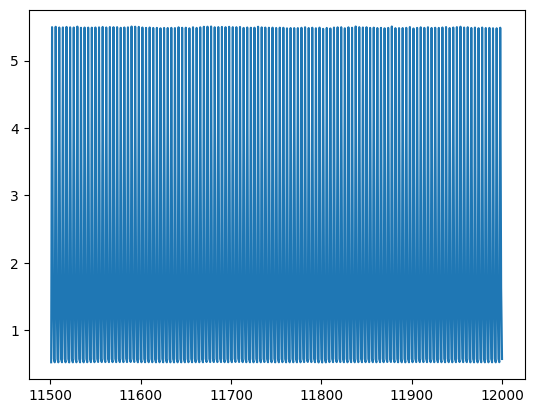

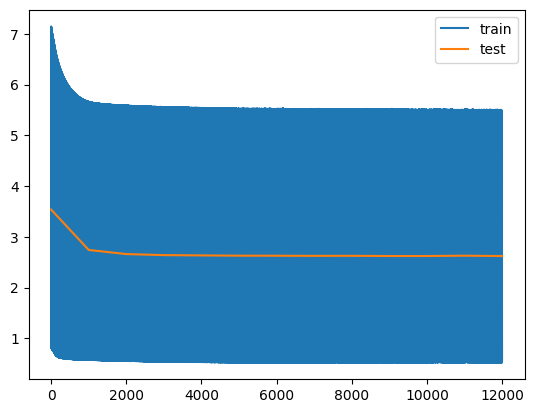

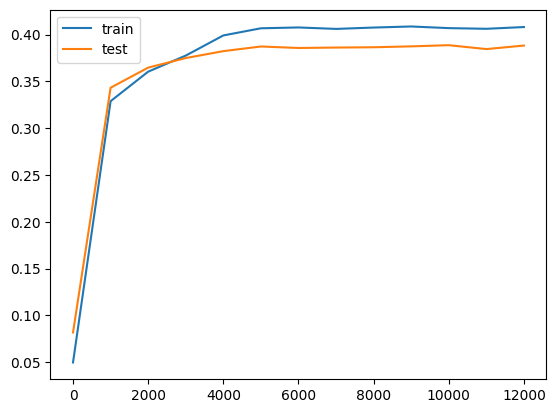

In [8]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

In [10]:
for idx, tr2 in enumerate(results["test_r2s"]):
    tra_r2 = results["train_r2s"][idx]
    print(tra_r2, tr2)
print(results["final_test_r2"])

(0, 0.049648549407720566) (0, 0.08169723115861416)
(1000, 0.3288554657995701) (1000, 0.34323740005493164)
(2000, 0.360393841098994) (2000, 0.3647116422653198)
(3000, 0.37758376330137255) (3000, 0.3749464452266693)
(4000, 0.3991013661026955) (4000, 0.3823123872280121)
(5000, 0.4067480382323265) (5000, 0.38729824125766754)
(6000, 0.40764418423175813) (6000, 0.3857053071260452)
(7000, 0.40607998535037043) (7000, 0.38615891337394714)
(8000, 0.40753855645656584) (8000, 0.3864767849445343)
(9000, 0.40868096888065336) (9000, 0.3874254524707794)
(10000, 0.4069164231419563) (10000, 0.3886900991201401)
(11000, 0.40620709598064425) (11000, 0.38452479243278503)
(12000, 0.4080786857008934) (12000, 0.3882884830236435)
0.38891996443271637


In [11]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -1.5
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

KeyError: 'MonkeyG_20150925_Session2_S1'

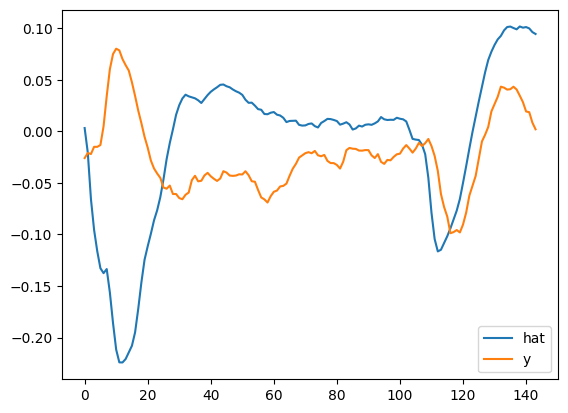

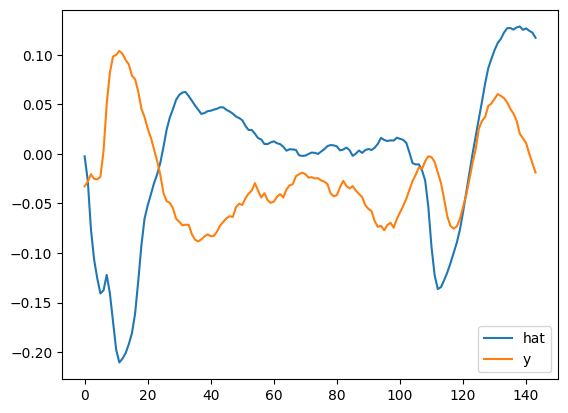

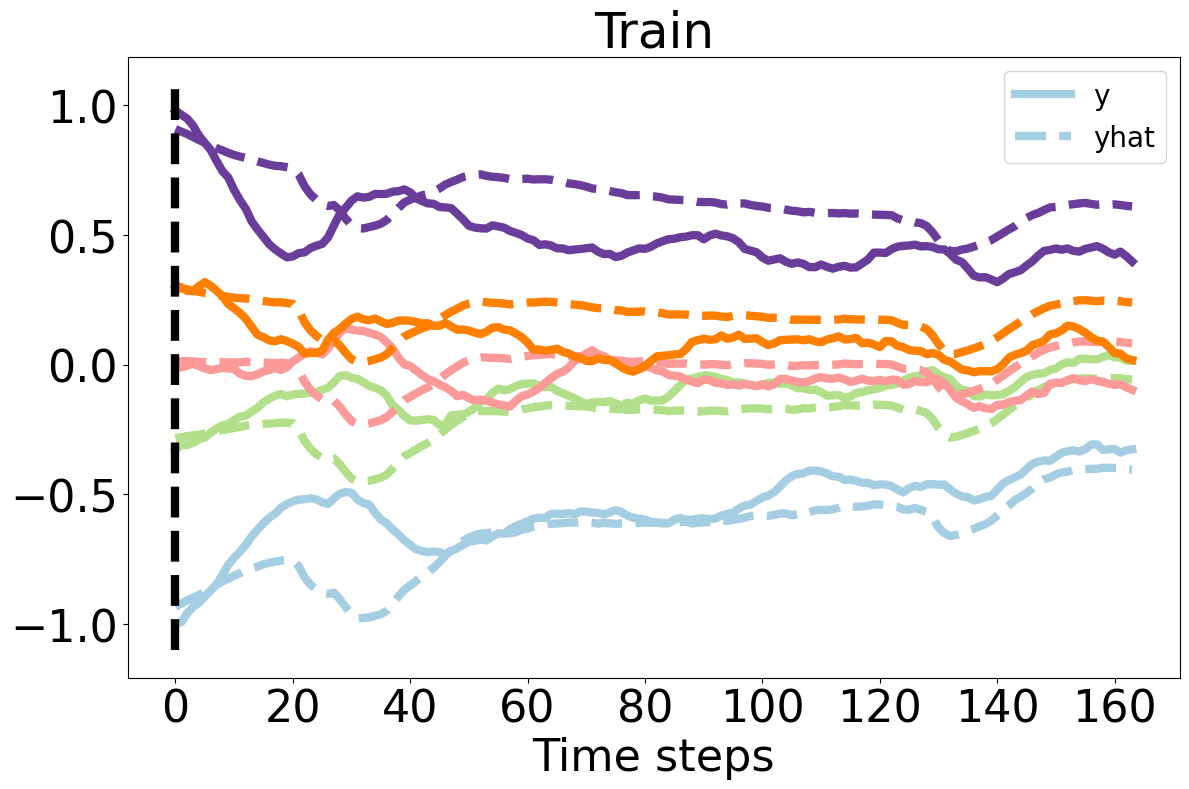

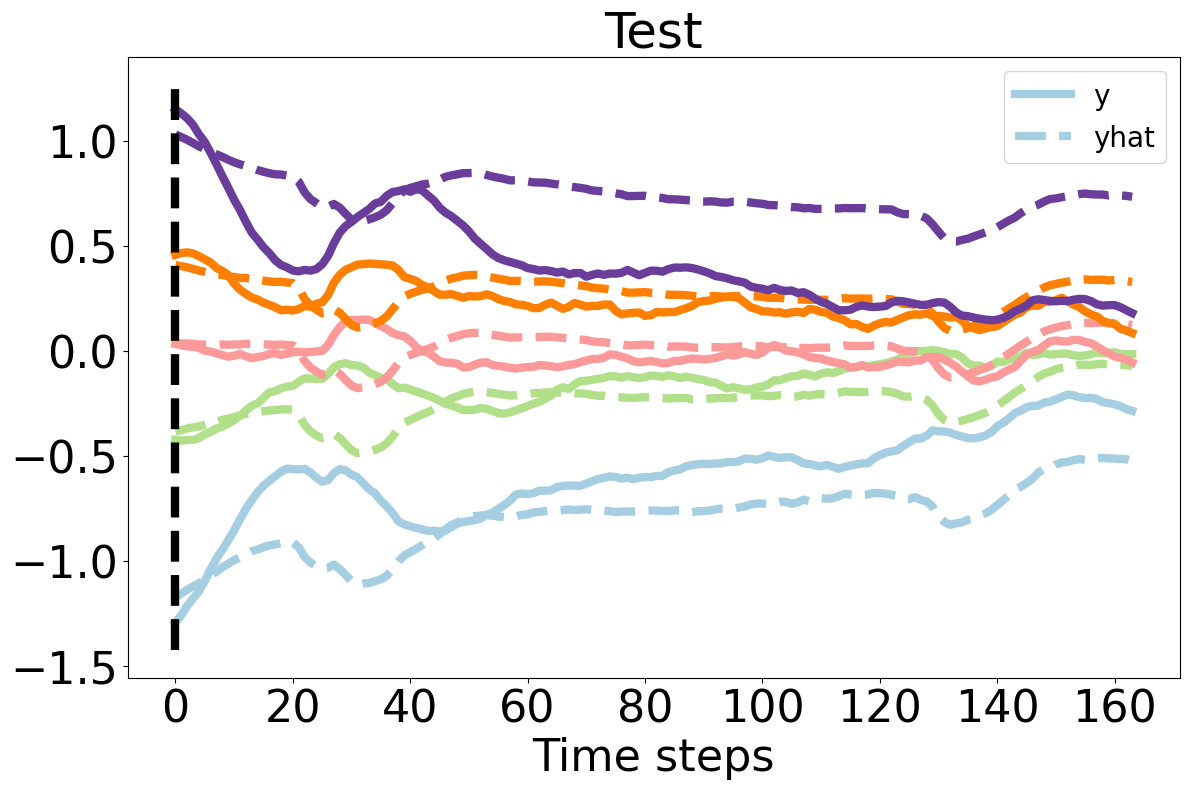

In [12]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    y_hat_mean = torch.mean(y_hats, dim=0)
    y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    y_mean = torch.mean(y, dim=0)
    y_test_mean = torch.mean(y_test, dim=0)
    
    plt.plot(y_hat_mean[20:, cidx], label="hat")
    plt.plot(y_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()

    plt.plot(y_hat_test_mean[20:, cidx], label="hat")
    plt.plot(y_test_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()
    
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)
    plt.show()
    
# graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
graph_for_sid('MonkeyG_20150918_Session1_M1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)

In [ ]:
# Try:
# cfg.training.grad_clip = 2.0, 7.0
# cfg.tbfm.training.lambda_ortho = 0.01, 0.05, 0.1
# cfg.tbfm.module.num_bases = 15, 20, 25

for grad_clip in (2.0,):
    for num_bases in (15, 20, 25):
        for lambda_ortho in (0.01, 0.05, 0.1):
            print("---------------", grad_clip, num_bases, lambda_ortho)

            # cfg.tbfm.training.lambda_fro = regweight
            cfg.tbfm.module.num_bases = num_bases
            cfg.training.grad_clip = grad_clip
            # cfg.latent_dim = latent_dim
            # cfg.tbfm.training.optim.lr_head = lr_head
            cfg.tbfm.training.lambda_ortho = lambda_ortho
            cfg.tbfm.module.use_film_bases = True
            # cfg.ae.training.coadapt = True
            cfg.training.epochs = 20001

            ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
            model_optims = multisession.get_optims(cfg, ms)
            
            embeddings_stim, results = multisession.train_from_cfg(
                cfg,
                ms,
                data_train,
                model_optims,
                embeddings_rest,
                data_test=data_test,
                test_interval=5000,
                epochs=20001,
                )
            torch.save(results, f"res_{grad_clip}_{num_bases}_{lambda_ortho}.torch")

            del model_optims, ms

--------------- 2.0 15 0.01
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1330499649047852 0.9247554540634155 0.03832010179758072 0.061805590987205505
basis_weighting.weight         grad_norm=2.0000e+00, weight_norm=2.1510e+00, ratio=9.2982e-01
basis_weighting.bias           grad_norm=6.7800e-02, weight_norm=3.8891e+00, ratio=1.7433e-02
bases.in_layer.weight          grad_norm=4.7441e-03, weight_norm=3.3024e+00, ratio=1.4365e-03
bases.in_layer.bias            grad_norm=1.5774e-03, weight_norm=1.0543e+00, ratio=1.4962e-03
bases.hiddens.0.weight         grad_norm=1.9571e-03, weight_norm=3.9004e+00, ratio=5.0177e-04
bases.hiddens.0.bias           grad_norm=8.5569e-04, weight_norm=7.5115e-01, ratio=1.1392e-03
bases.hiddens.1.weight         grad_norm=1.9006e-03, weight_norm=3.8063e+00, ratio=4.9934e-04
bases.hiddens.1.bias           grad_norm=6.2266e-04, weight_norm=7.2910e-01, ratio=8.5402e-04
bases.out_layer.weight         

In [10]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)

# (0.4557589888572693, './res_0.07_17_70_10.0.torch')
# (0.4561246633529663, './res_0.05_12_50_10.0.torch')
# (0.45635348558425903, './res_0.01_17_70_10.0.torch')
# (0.4564235210418701, './res_0.07_17_70_1000.torch')
# (0.4569217562675476, './res_0.05_17_50_10.0.torch')
# (0.45701655745506287, './res_0.05_17_50_1000.torch')
# (0.4574051797389984, './res_0.05_20_70_1000.torch')
# (0.4576779007911682, './res_0.05_15_50_1000.torch')
# (0.45774632692337036, './res_0.05_15_70_1000.torch')
# (0.4579020142555237, './res_0.05_17_70_10.0.torch')

# Fro 0.05
# num_bases 17
# latent dim 70
# clip_grad None

(0.35666774378882515, './res_0.05_50_0.0003_0.2.torch')
(0.35697651902834576, './res_0.01_70_0.0003_0.3.torch')
(0.3569850954744551, './res_0.01_70_0.0001_0.1.torch')
(0.35736728376812404, './res_0.01_70_0.0001_0.3.torch')
(0.357471548848682, './res_0.01_50_0.0003_0.1.torch')
(0.35761067602369523, './res_0.01_70_0.0002_0.2.torch')
(0.35779477490319145, './res_0.01_70_0.0003_0.2.torch')
(0.3578372299671173, './res_0.01_70_0.0003_0.1.torch')
(0.35784753163655597, './res_0.01_50_0.0003_0.2.torch')
(0.357981413602829, './res_0.01_70_0.0002_0.1.torch')


In [25]:
# Let's try TTA
new_stim_embeddings, results_tta = multisession.test_time_adaptation(cfg, ms, embeddings_rest, data_train, epochs=2000, data_test=data_test)
print(results["final_test_r2s"])

0 0.6222979426383972
100 0.6133788824081421
200 0.6136006712913513
300 0.6139000654220581
400 0.6141868233680725
500 0.6131638288497925
600 0.6138451099395752
700 0.6133682131767273
800 0.6135589480400085
900 0.613442599773407
1000 0.6130519509315491
1100 0.6133544445037842
1200 0.6130642294883728
1300 0.6139163970947266
1400 0.6139088273048401
1500 0.6133326292037964
1600 0.6134396195411682
1700 0.6133860349655151
1800 0.6138848066329956
1900 0.6135591268539429
{'MonkeyG_20150914_Session1_S1': 0.7232637405395508, 'MonkeyG_20150914_Session3_S1': 0.4463784545660019, 'MonkeyG_20150915_Session3_S1': 0.32424600422382355, 'MonkeyG_20150916_Session4_S1': 0.7238639891147614, 'MonkeyG_20150917_Session1_M1': 0.14471077919006348, 'MonkeyG_20150917_Session1_S1': 0.2508350610733032, 'MonkeyG_20150917_Session2_M1': 0.19137732312083244, 'MonkeyG_20150917_Session2_S1': 0.7244466543197632, 'MonkeyG_20150917_Session3_M1': 0.12579362466931343, 'MonkeyG_20150918_Session1_M1': 0.46722058951854706, 'Monkey

tensor([-0.6266, -0.6333, -0.6443, -0.6549, -0.6619, -0.6717, -0.6846, -0.6994,
        -0.7133, -0.7301], device='cuda:0')
------
tensor([-0.3107, -0.0245,  0.6887, -0.2646,  0.1200,  0.1247,  0.1620, -0.3577,
         0.5891, -0.4173], device='cuda:0') tensor([ 0.3438,  0.0594, -1.1106,  0.7617, -0.2339, -0.2169, -0.3324,  0.8963,
        -1.7553,  0.6009], device='cuda:0')
tensor([-0.5812, -0.5836, -0.5919, -0.6043, -0.6289, -0.6439, -0.6515, -0.6666,
        -0.6897, -0.7096], device='cuda:0')


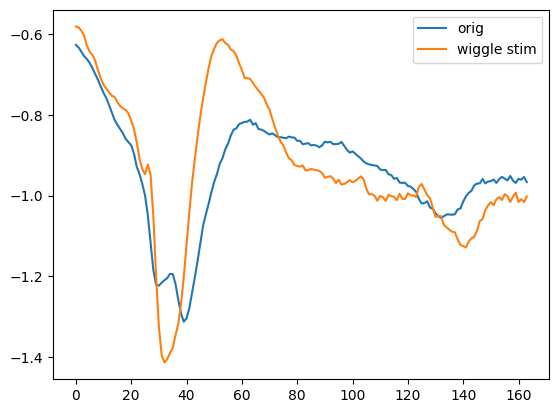

In [26]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    # preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    # plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    # print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(new_stim_embeddings, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

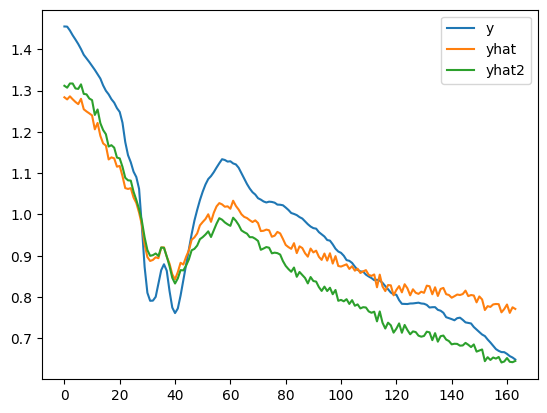

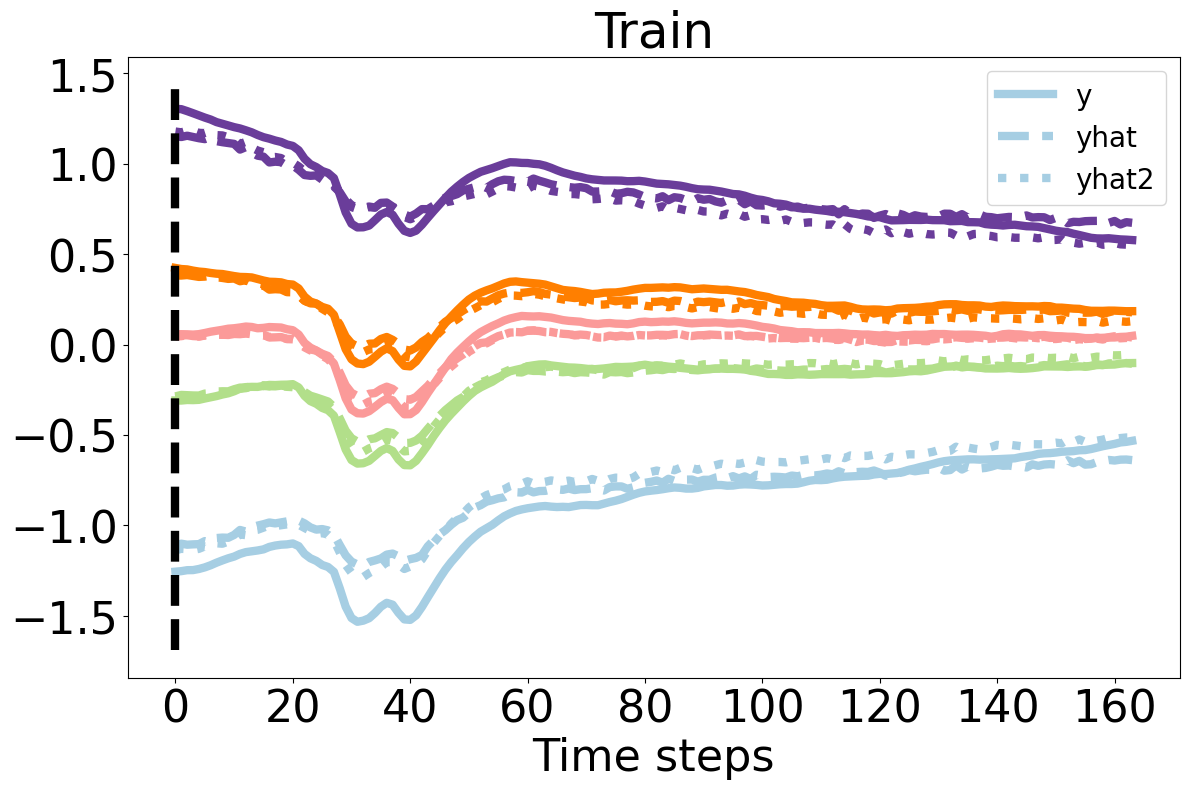

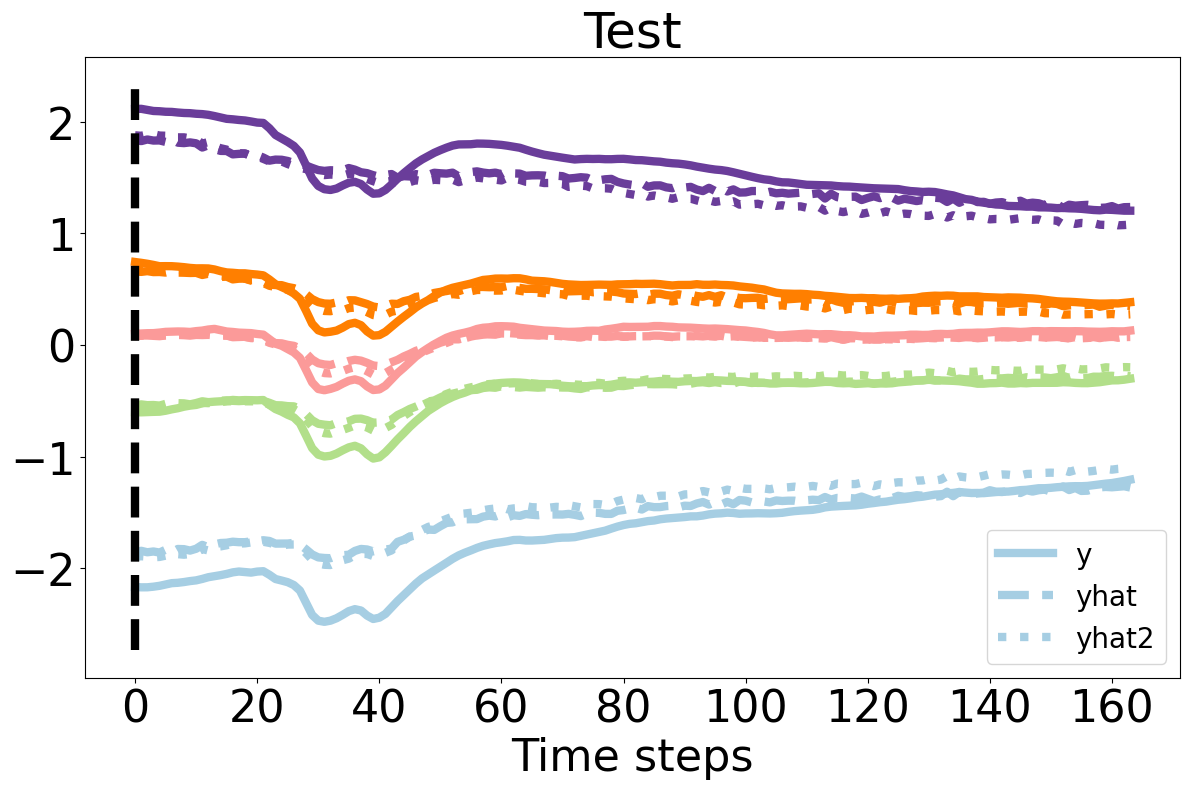

In [ ]:
def graph_for_sid_tta(sid, results, results_tta, data_train, model, new_stim_embeddings, cfg, support_size=300, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    y_hats_test2 = results_tta['y_hat_test'][sid].detach().cpu()

    model.eval()
    with torch.no_grad():
        dt = {sid: next(iter(data_train))[sid]}
        dt = utils.move_batch(dt, device=DEVICE)
        
        # Apply outlier filtering to match training behavior
        dt, filter_stats = utils.filter_batch_outliers(dt, model.norms, cfg)
        if cfg.training.use_outlier_filtering:
            print(f"Filtered {filter_stats['per_session'][sid][1] - filter_stats['per_session'][sid][0]} outlier trials")
        
        d = dt[sid]
        y_norm = model.norms.instances[sid](d[2])             
        new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])                    
        dt = {sid: new_d}
        y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)[sid]

    _y = []
    _yhat = []
    _yhat2 = []
    for bidx in range(y_hats2.shape[0]):
        __y = dt[sid][2][bidx, :, cidx]
        if __y[0] > 0.8:
            _y.append(__y.unsqueeze(0))
            _yhat.append(y_hats[bidx, :, cidx].unsqueeze(0))
            _yhat2.append(y_hats2[bidx, :, cidx].unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, yhat2=y_hats2, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, yhat2=y_hats_test2, title="Test", runway_length=0, ch=cidx)

graph_for_sid_tta('MonkeyG_20150925_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cfg, cidx=30)

In [21]:
print(results.keys())

dict_keys(['final_test_r2', 'final_test_r2s', 'final_test_loss', 'y_hat_test', 'y_test'])
